In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sklearn
print(sklearn.__version__)

1.0.2


In [4]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [5]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [6]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path, snana_ob_type_name
from kndetect.features import extract_features_all_lightcurves, get_feature_names
from kndetect.training import append_y_true_col
from kndetect.predict import filter_no_coeff_events
from kndetect.activelr import run_AL_loops

In [7]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [8]:
use_already_trained_features = True
use_already_trained_models = True
mimic_alerts = True
save_data = True
save_results_plots = True
sub_directory=None

use_AL = True
use_already_trained_AL_features = True

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"
    
plot_path_prefix=None
if save_results_plots:
    plot_path_prefix = sub_directory

In [9]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [10]:
filter_indices = filter_no_coeff_events(train_features_df)
filtered_train_features_df = train_features_df[filter_indices]

In [11]:
num_kn_train = len(filtered_train_features_df[filtered_train_features_df["y_true"]==True])
num_non_kn_train = len(filtered_train_features_df[filtered_train_features_df["y_true"]==False])

In [12]:
print("Total KN events in train set: {}".format(num_kn_train))
print("Total non KN events in test set: {}".format(num_non_kn_train))
print("Total number of events: {}".format(num_kn_train + num_non_kn_train))

Total KN events in train set: 1448
Total non KN events in test set: 12099
Total number of events: 13547


In [13]:
if use_AL:
    if use_already_trained_AL_features:
        data_path=os.path.join(data_dir, sub_directory, "AL", "train.csv")
        filtered_train_features_df = pd.read_csv(data_path)
    else:
        data_base_path=os.path.join(data_dir, sub_directory)
        feature_names = get_feature_names()
        filtered_train_features_df = filtered_train_features_df[['key', 'y_true'] + feature_names]
        filtered_train_features_df.reset_index(inplace=True, drop=True)

        filtered_train_features_df = run_AL_loops(features_df=filtered_train_features_df, save_data=save_data, nloops=1490, data_base_path=data_base_path)

In [14]:
filtered_train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,y_true
0,0.717387,-0.024121,0.252385,1.058158,252.205719,0.631842,0.029325,0.362497,1.991651,574.391724,2663180,True
1,0.626298,0.066222,0.391000,1.607111,367.761475,0.643907,-0.015280,0.373226,6.382234,1720.759399,7100715,True
2,1.151724,-0.147801,0.002646,1.118269,1095.733887,1.024105,-0.088619,0.065001,0.986994,748.958496,13970871,False
3,0.551938,0.014075,0.446718,1.488882,263.121643,0.715331,-0.037291,0.349520,1.413218,364.587891,19644471,True
4,0.801358,0.101799,0.214871,5.651549,3485.352295,0.791769,0.086295,0.227875,6.480857,3297.369873,35443816,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.947738,0.129999,0.045534,2.932235,3748.726074,0.512907,0.410130,0.103278,0.293215,208.157272,136739588,False
1496,0.865842,0.002899,0.150426,4.708209,2349.095459,0.957245,0.124714,0.008591,1.606565,1103.184570,80019844,False
1497,0.789940,0.204597,0.178245,1.750774,451.302277,0.791369,0.058882,-0.226521,0.807008,836.751648,119088416,False
1498,0.710074,0.260334,-0.220048,11.243679,4547.690430,0.747008,0.174416,0.269518,3.488938,2894.814941,69604744,False


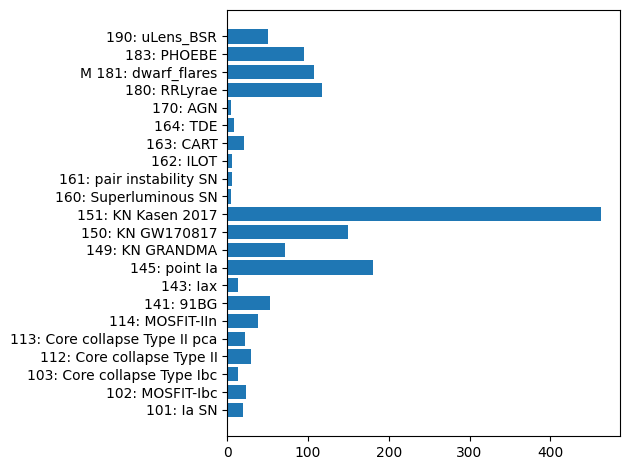

In [15]:
al_distribution = {}
for SNTYPE in np.unique(df_header["SNTYPE"].values):
    al_distribution[SNTYPE] = 0

for key in filtered_train_features_df["key"]:
    row = df_header[df_header["SNID"] == key]
    al_distribution[row["SNTYPE"].values[0]]+=1
    

al_type_names = []
al_freq = []
for key in al_distribution.keys():
    al_type_names.append(snana_ob_type_name(key))
    al_freq.append(al_distribution[key])

plt.barh(al_type_names, al_freq)
plt.tight_layout()

if save_results_plots:
    plt.savefig(os.path.join("results", sub_directory, "al_event_distribution"))

In [16]:
num_kn_train_final = len(filtered_train_features_df[filtered_train_features_df["y_true"]==True])
num_non_kn_train_final = len(filtered_train_features_df[filtered_train_features_df["y_true"]==False])

In [17]:
print("Total KN events in train set: {}".format(num_kn_train_final))
print("Total non KN events in test set: {}".format(num_non_kn_train_final))
print("Total number of events: {}".format(num_kn_train_final + num_non_kn_train_final))

Total KN events in train set: 684
Total non KN events in test set: 816
Total number of events: 1500


# Now Train the classifier

In [18]:
from kndetect.training import train_classifier
from kndetect.predict import load_classifier, predict_kn_score

In [19]:
if not use_already_trained_models:
    clf, filtered_train_features_df = train_classifier(filtered_train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")
    probabilities, filtered_indices = predict_kn_score(clf, filtered_train_features_df)
    filtered_train_features_df['y_score'] = probabilities.T[1]
    filtered_train_features_df['y_pred'] = filtered_train_features_df['y_score']>.5

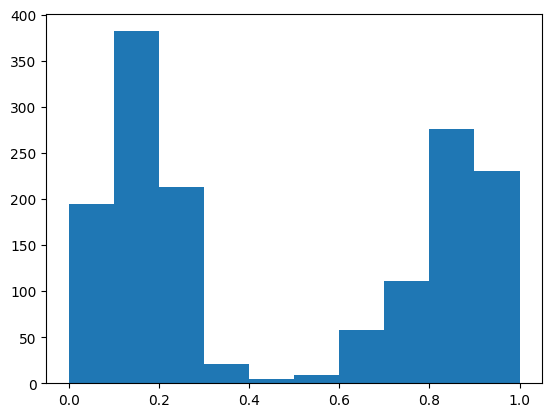

In [20]:
fig = plt.figure()
plt.hist(filtered_train_features_df['y_score']);
plt.savefig("score_distrib")

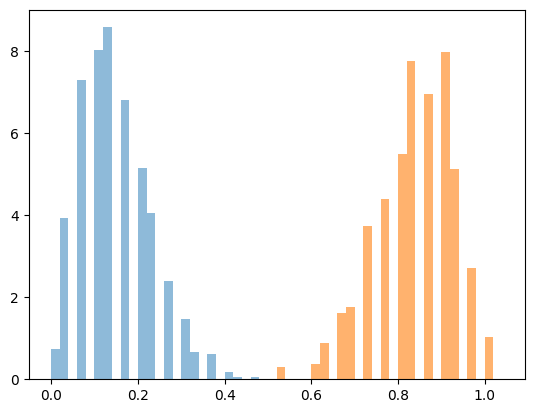

In [21]:
bins = np.arange(0,1.05, .02)
hist = plt.hist(filtered_train_features_df[filtered_train_features_df['y_true']==0]['y_score'], bins=bins, density=True, alpha=0.5)
hist = plt.hist(filtered_train_features_df[filtered_train_features_df['y_true']==1]['y_score'], bins=bins, density=True, alpha=0.6)


plt.savefig("train_scores_distrib")

In [22]:
# Generate Test features and Predict probabilities

In [23]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [24]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [25]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)
test_features_df['y_score'] = probabilities.T[1]
filtered=test_features_df[filtered_indices]

In [26]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_score"]>0.5

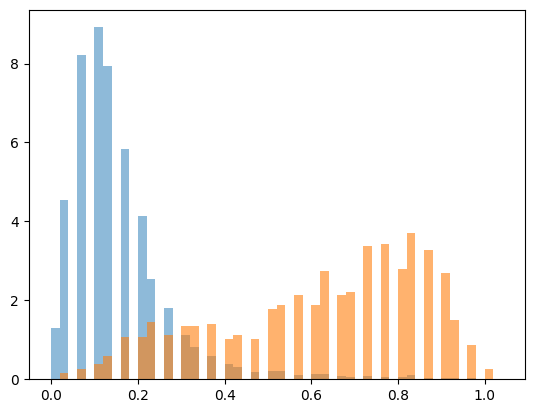

In [27]:
%matplotlib inline
bins = np.arange(0,1.05, .02)
hist = plt.hist(filtered[filtered['y_true']==0]['y_score'], bins=bins, density=True, alpha=0.5)
hist = plt.hist(filtered[filtered['y_true']==1]['y_score'], bins=bins, density=True, alpha=0.6)


plt.savefig("test_scores")

In [28]:
y1 = filtered[filtered['y_true']==0]['y_pred_score']
y2 = filtered[filtered['y_true']==1]['y_pred_score']

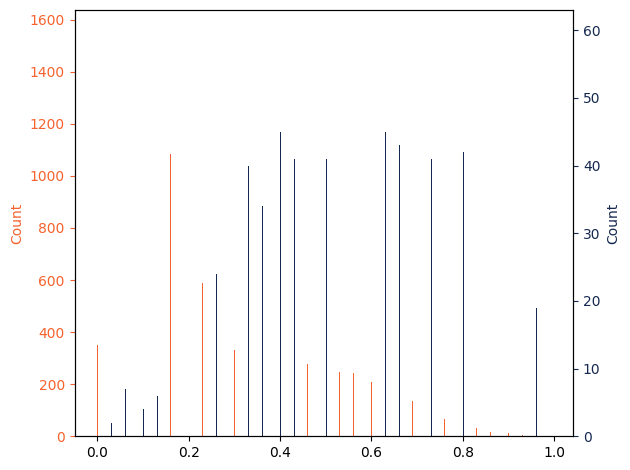

In [29]:
colors=['#F5622E', '#15284F']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([y1, y2])
n, bins, patches = ax1.hist([y1,y2], bins=100)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.1
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

In [30]:
y_true_train = filtered_train_features_df["y_true"]
y_pred_train = filtered_train_features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))


train statistics:

total number of events: 1500
total number of KN: 684
total number of non KN: 816

True Positive : 684
False Positive : 0
True negative : 816
False negative : 0


In [31]:
tp = np.sum(y_true&y_pred)
fp = np.sum(~y_true&y_pred)
tn = np.sum(~y_true&~y_pred)
fn = np.sum(y_true&~y_pred)

In [32]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {}".format(tp))
print("False Positive : {}".format(fp))
print("True negative : {}".format(tn))
print("False negative : {}".format(fn))

test statistics:

total number of events: 13125
total number of KN: 932
total number of non KN: 12193

True Positive : 650
False Positive : 288
True negative : 11905
False negative : 282


In [33]:
print("Total num of KN train + test : {}".format(num_kn_train + np.sum(y_true)))
print("Total num of non KN train + test : {}".format(num_non_kn_train + np.sum(~y_true)))
print("Total number of events : {}".format(num_kn_train + np.sum(y_true) + num_non_kn_train + np.sum(~y_true)))

Total num of KN train + test : 2380
Total num of non KN train + test : 24292
Total number of events : 26672


In [34]:
precision = tp * 100 / (tp+fp)
recall = tp*100 / (tp+fn)

print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))

Precision: 69.30%
Recall: 69.74%


In [35]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

[[0.90704762 0.02194286]
 [0.02148571 0.04952381]]


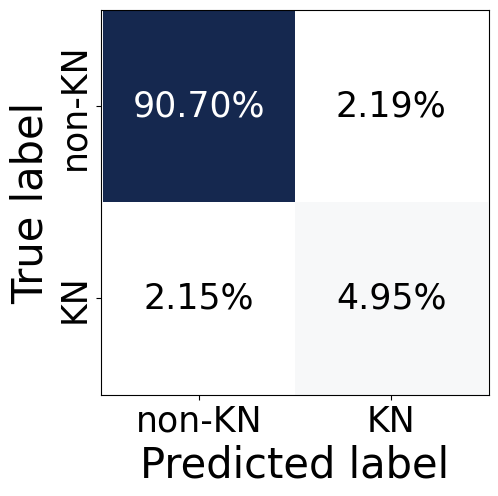

In [36]:
from kndetect.plot_lightcurve import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred, save_fig_prefix=plot_path_prefix)

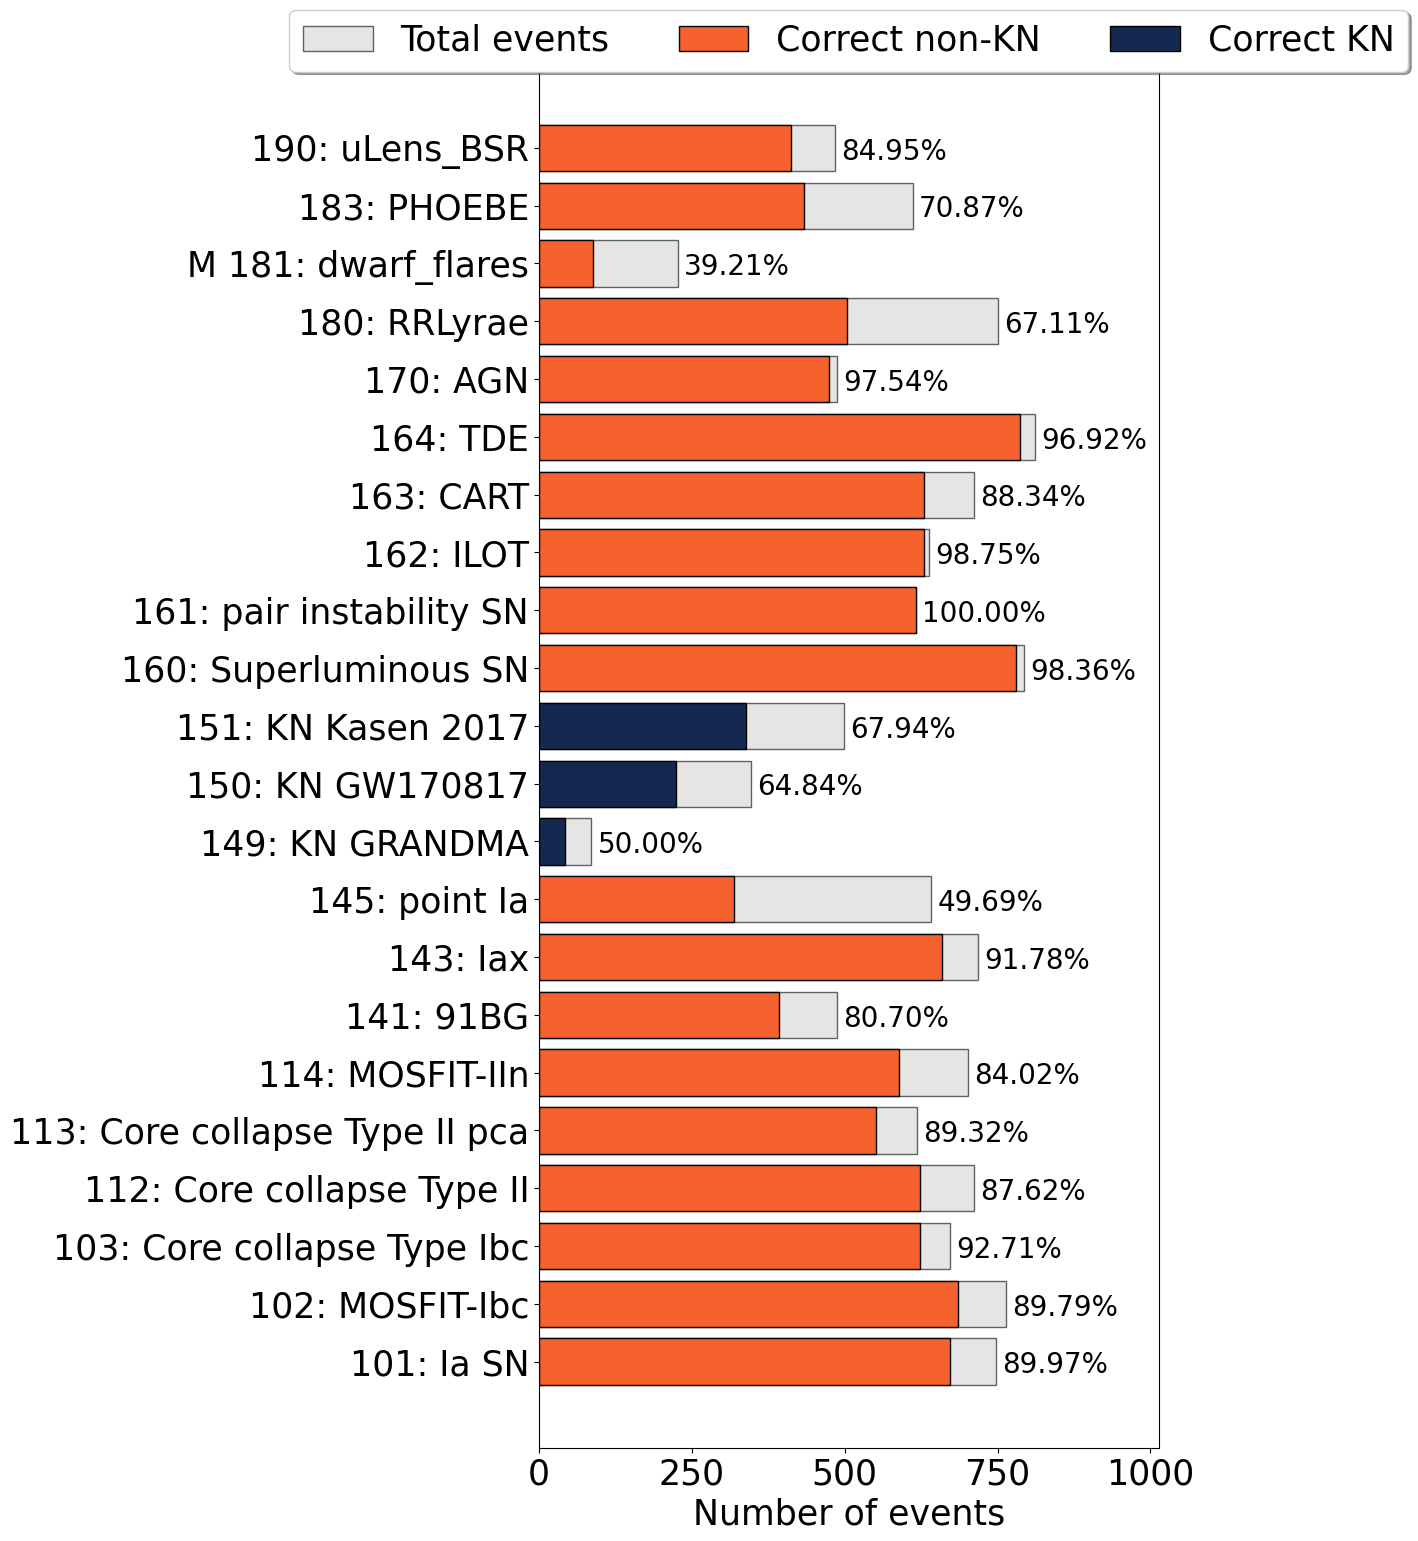

In [37]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,18))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151], save_fig_prefix=plot_path_prefix)
plt.show()

In [38]:
from kndetect.plot_lightcurve import plot_band_correlation
from kndetect.plot_lightcurve import plot_features_correlation
import seaborn as sns

Using matplotlib backend: <object object at 0x7f2770a58270>


/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndetect/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contou

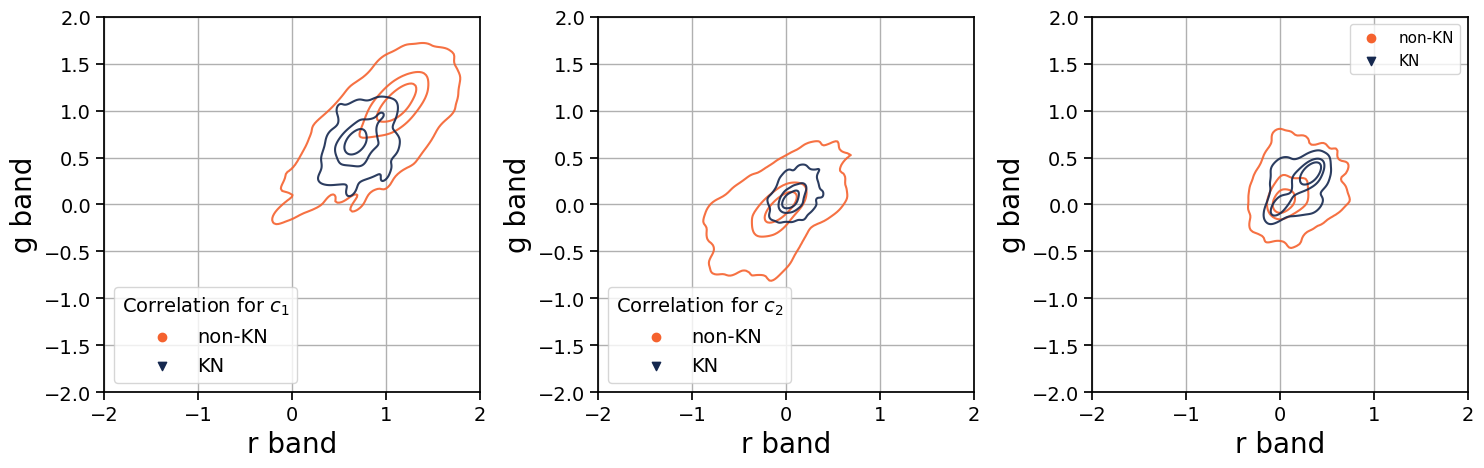

In [39]:
%matplotlib
plot_band_correlation(filtered, bands=['g','r'], x_limits=[-2,2], y_limits=[-2,2], num_kn_points=3000, num_non_kn_points=10000, save_fig_prefix=plot_path_prefix)

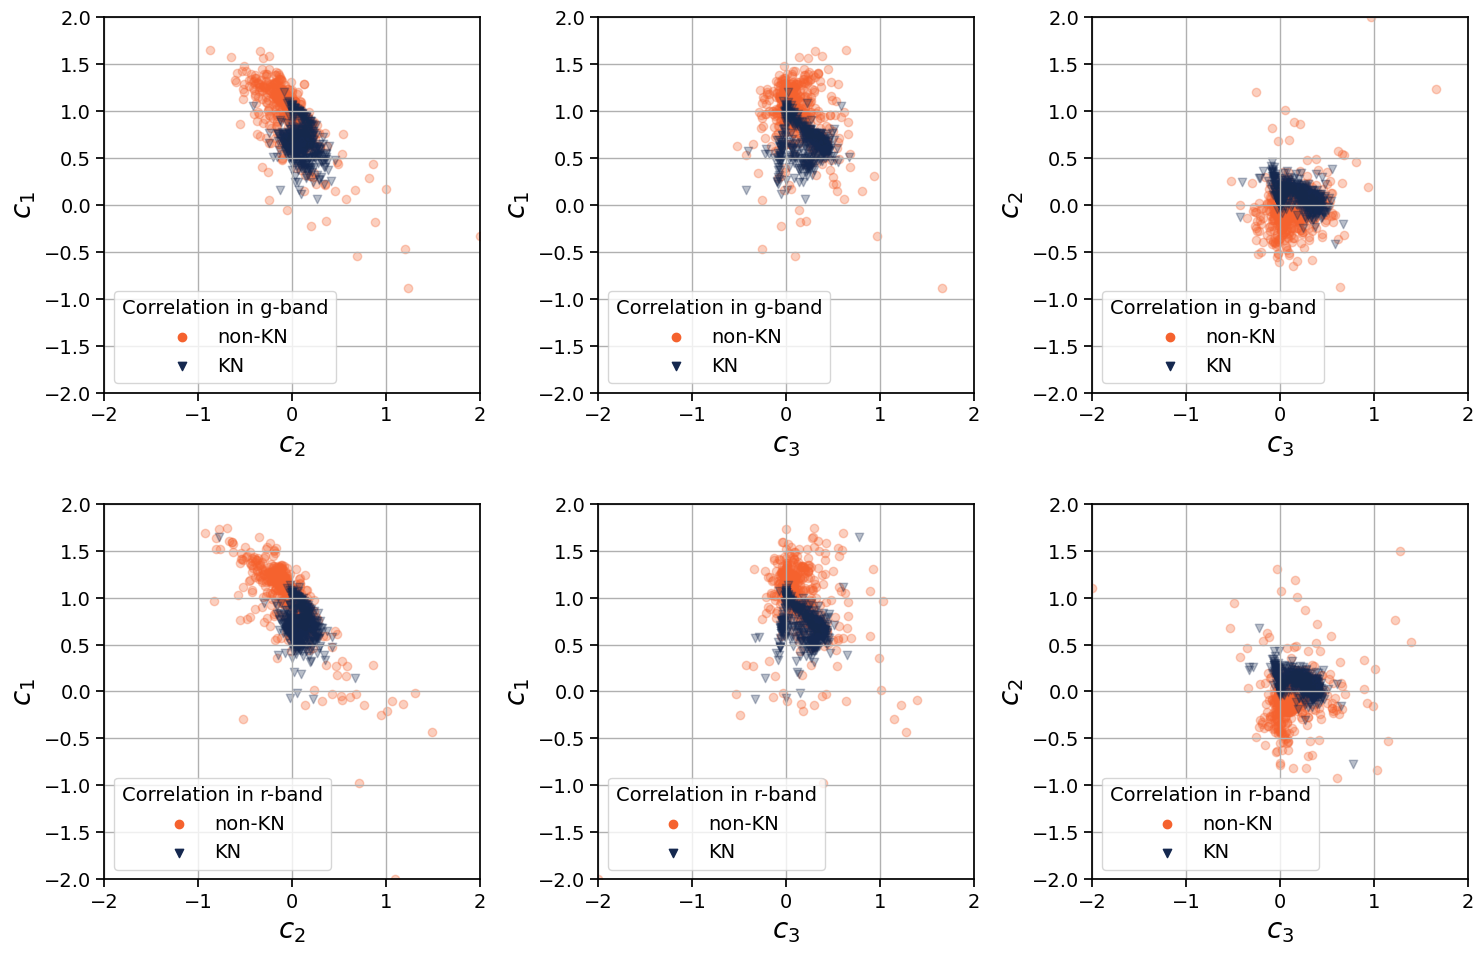

In [40]:
plot_features_correlation(filtered, color_dict = {'non_kn':'#F5622E', 'kn': '#15284F'},bands=['g','r'], x_limits=[-2,2], y_limits=[-2,2], num_kn_points=500, num_non_kn_points=500, save_fig_prefix=plot_path_prefix)

In [41]:
filtered

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred_score,y_score
0,0.634581,0.199713,-0.045995,4.704726,3813.011456,1.078646,-0.003711,0.001587,0.511555,5518.907806,1612,2.2000,149,149: KN GRANDMA,True,0.266667,0.333333
1,1.421258,-0.445095,0.020762,3.276473,1215.978638,1.557321,-0.633489,-0.011362,8.299686,1606.578125,10871,57684.3980,162,162: ILOT,False,0.233333,0.200000
2,0.997868,0.077395,0.001676,1.036327,764.863892,1.060236,0.001999,-0.001891,0.369271,805.522644,10872,57686.1484,150,150: KN GW170817,True,0.233333,0.100000
4,0.424323,0.028721,0.435591,38.152115,20902.640625,0.377962,0.234933,0.369341,34.203294,7671.299316,13390,57496.2870,180,180: RRLyrae,False,0.333333,0.200000
5,0.735719,-0.129366,0.335152,1.173700,229.550552,0.181532,0.091817,0.140999,0.945434,243.924194,13997,57490.4224,150,150: KN GW170817,True,0.466667,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21283,0.985055,-0.025497,0.122945,1.393851,915.629395,1.034206,-0.208213,0.127777,1.448095,1154.043457,137049400,57477.4392,183,183: PHOEBE,False,0.133333,0.133333
21284,0.564814,-0.071464,0.451095,1.550917,229.678802,0.467558,0.282210,-0.199860,2.852567,785.573853,137051059,57641.4133,181,M 181: dwarf_flares,False,0.600000,0.366667
21285,0.957386,-0.058006,0.132150,0.749828,374.421295,1.167186,-0.153968,0.015495,1.040311,341.236908,137054088,57493.3787,143,143: Iax,False,0.033333,0.133333
21286,0.912135,0.122197,0.193269,1.167749,1000.960266,0.519934,-0.011211,0.357229,5.312823,3378.102295,137071432,57618.4770,181,M 181: dwarf_flares,False,0.500000,0.433333


In [42]:
num_points_g = []
num_points_r = []

for snid, current_date in zip(filtered["key"], filtered["current_dates"]):

    current_obj = df_phot_test[df_phot_test["SNID"] == snid]
    
    start_date = current_date -30 
    current_obj = current_obj[(current_obj["MJD"]>=start_date) & (current_obj["MJD"]<=current_date)] 
    
    g_df = current_obj[current_obj["FLT"] == b'g']
    num_points = np.sum([g_df["FLUXCAL"] >= 200])
    #num_points = len(g_df)
    num_points_g.append(num_points)
    
    r_df = current_obj[current_obj["FLT"] == b'r']
    num_points = np.sum([r_df["FLUXCAL"] >= 200])
    #num_points = len(r_df)
    num_points_r.append(num_points)


In [43]:
filtered["num points g"] = num_points_g
filtered["num points r"] = num_points_r
filtered["num points"] = np.array(num_points_g) + np.array(num_points_r)

/tmp/ipykernel_640/1398018680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["num points g"] = num_points_g
/tmp/ipykernel_640/1398018680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["num points r"] = num_points_r
/tmp/ipykernel_640/1398018680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [44]:
kndf = filtered[filtered["y_true"] == True]
nonkndf = filtered[filtered["y_true"] == False]

In [45]:
plot_df = filtered[filtered["y_score"] >.5]

In [46]:
plot_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred_score,y_score,num points g,num points r,num points
10,0.992581,-0.004162,0.003981,0.366426,539.083836,0.727069,-0.087910,0.197118,2.456543,1015.577335,21224,4.0000,149,149: KN GRANDMA,True,0.466667,0.533333,2,3,5
23,0.615369,0.221676,-0.067660,2.225785,916.275613,0.753357,0.295091,-0.054733,7.441750,8618.461680,72989,5.2000,149,149: KN GRANDMA,True,0.800000,0.766667,3,4,7
36,0.317519,0.260759,-0.075129,10.058243,5099.947345,0.672385,0.249250,-0.051418,5.227436,4777.853383,111974,4.1000,149,149: KN GRANDMA,True,0.700000,0.833333,3,4,7
46,0.606864,0.008913,0.429506,3.622799,1558.564941,0.625288,-0.093767,0.433873,8.023393,4038.556152,134796,57439.3071,150,150: KN GW170817,True,0.366667,0.733333,1,1,2
48,0.630809,-0.040329,0.353702,2.677988,481.490265,0.426997,0.107147,0.294709,5.877670,1330.023315,139362,57692.1922,150,150: KN GW170817,True,0.733333,0.900000,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21111,0.899321,0.142085,0.120162,1.540271,985.874573,0.675879,0.210823,-0.046676,5.044333,2139.298096,135740361,57452.1364,181,M 181: dwarf_flares,False,1.000000,0.833333,2,1,3
21157,0.313434,0.171884,0.277323,9.534912,2302.997070,0.469461,0.082881,0.319719,9.218101,2486.598877,136102334,57641.4438,151,151: KN Karsen 2017,True,0.900000,0.666667,2,3,5
21168,0.648643,-0.052419,0.353531,9.342829,2483.381836,1.014212,0.057120,-0.005433,1.303107,1529.011597,136232757,57575.4181,181,M 181: dwarf_flares,False,0.366667,0.566667,1,1,2
21175,0.506074,-0.017820,0.383193,4.458947,1407.732300,0.426856,0.009675,0.269084,5.545408,1896.199585,136279934,57507.2959,151,151: KN Karsen 2017,True,0.566667,0.766667,1,2,3


In [47]:
sns.scatterplot(data=plot_df, x="num points", y="y_score", hue="y_true", alpha=.3)

<AxesSubplot:xlabel='$c_3$', ylabel='$c_2$'>

In [48]:
import seaborn as sns
%matplotlib inline

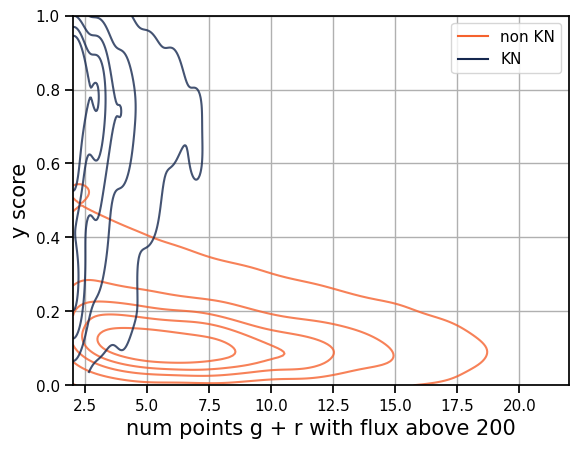

In [49]:
ax = sns.kdeplot(data=filtered, x="num points", y="y_score", hue="y_true", common_norm=False, levels=6, legend=False, palette=['#F5622E', '#15284F'], alpha=.8, cut=0)

ax.plot([], [], label = "non KN", color='#F5622E')
ax.plot([], [], label = "KN", color='#15284F')
ax.legend()
ax.set_xlabel("num points g + r with flux above 200", fontsize=15)
ax.set_ylabel("y score", fontsize=15)
#ax.set_xlim((0,20))
plt.savefig("results/partial/scorevsnumpoints")
plt.savefig("results/partial/scorevsnumpoints.pdf")

Text(0, 0.5, 'frequency')

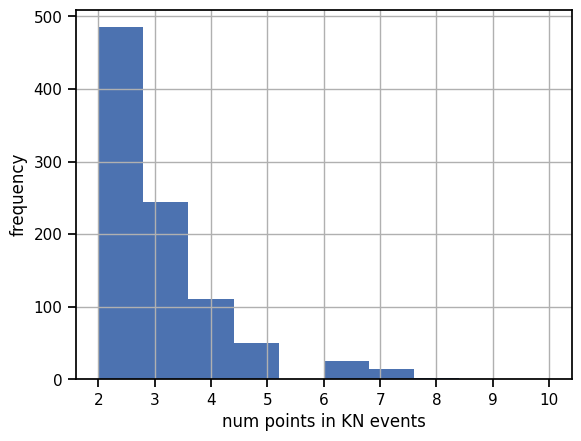

In [50]:
plt.hist(filtered[filtered["y_true"]]["num points"])
plt.xlabel("num points in KN events")
plt.ylabel("frequency")